<a href="https://colab.research.google.com/github/shuyaguan/0826/blob/main/Riya%26Shuya_DeepLearning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUSA 650 Final Assignment Proposal: Remote Sensing Solution for Urban Planning**

## **Flood Mapping for Urban Disruptions and Emergency Response**

Shuya Guan and Riya Saini


# 1. Dataset Exploration

In [28]:
# Essential imports for data exploration
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
!pip install rasterio
import rasterio
from torchvision import transforms


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define dataset directory
data_dir = "/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD"

In [30]:
# List all TIFF files recursively
tif_files = glob.glob(os.path.join(data_dir, "**/*.tif"), recursive=True)
print(f"Total TIFF files found: {len(tif_files)}")

# Print sample file paths
print("Sample file paths:")
for f in tif_files[:5]:
    print(f)

s1_files = [f for f in tif_files if "S1" in f]
s2_files = [f for f in tif_files if "S2" in f]
print(f"Sentinel-1 (S1) images : {len(s1_files)}")
print(f"Sentinel-2 (S2) images : {len(s2_files)}")

Total TIFF files found: 28300
Sample file paths:
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/new.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181216T172604_20181216T172629_025053_02C3AD_6EEA_corrected_VH.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173347_20181221T173412_025126_02C648_A3BD_corrected_VH.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173347_20181221T173412_025126_02C648_A3BD_corrected_VV.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173412_20181221T173437_025126_02C648_B354_corrected_VV.tif
Sentinel-1 (S1) images : 4324
Sentinel-2 (S2) images : 23975


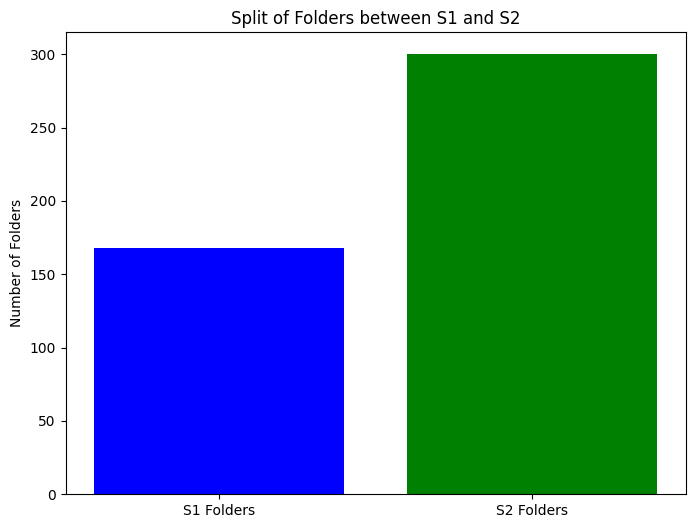

In [31]:
# Count the number of S1 and S2 folders
s1_folder_count = len(set(os.path.dirname(f) for f in s1_files))
s2_folder_count = len(set(os.path.dirname(f) for f in s2_files))

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(["S1 Folders", "S2 Folders"], [s1_folder_count, s2_folder_count], color=['blue', 'green'])
plt.title("Split of Folders between S1 and S2")
plt.ylabel("Number of Folders")
plt.show()

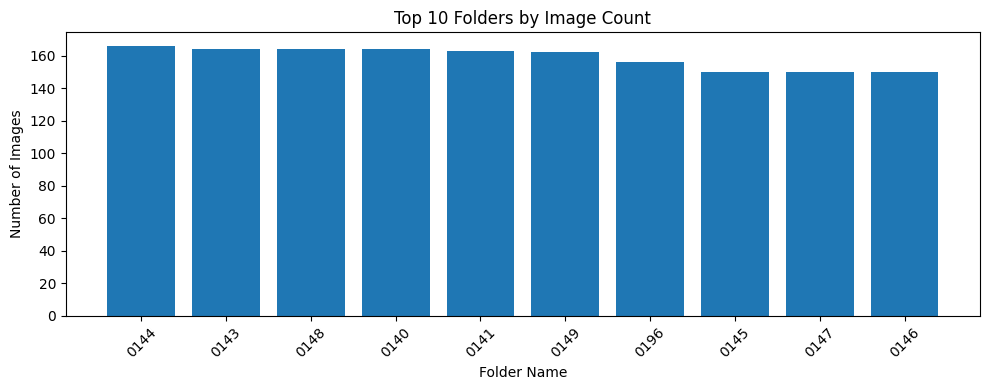

In [32]:
# Plot distribution of folders
folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
folder_counts = Counter(folder_names)
df_folder_counts = pd.DataFrame(list(folder_counts.items()), columns=["Folder", "Count"])
df_folder_counts = df_folder_counts.sort_values("Count", ascending=False).head(10)

plt.figure(figsize=(10, 4))
plt.bar(df_folder_counts["Folder"], df_folder_counts["Count"])
plt.title("Top 10 Folders by Image Count")
plt.xlabel("Folder Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# Load metadata JSON files
s1_json_path = os.path.join(data_dir, "S1list.json")
s2_json_path = os.path.join(data_dir, "S2list.json")

flood_labels = {}
# Load Sentinel-1 metadata
if os.path.exists(s1_json_path):
    with open(s1_json_path, "r") as f:
        s1_data = json.load(f)

    # Extract flood labels
    for folder, details in s1_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items()
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)

# Load Sentinel-2 metadata
if os.path.exists(s2_json_path):
    with open(s2_json_path, "r") as f:
        s2_data = json.load(f)

    # Update flood labels
    for folder, details in s2_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items()
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)

Flood Label Mapping (Sample):
Folder: 0063, Flooding: 0
Folder: 0200, Flooding: 1
Folder: 0004, Flooding: 0
Folder: 0307, Flooding: 1
Folder: 0167, Flooding: 1
Folder: 0205, Flooding: 1
Folder: 0166, Flooding: 1
Folder: 0240, Flooding: 1
Folder: 0123, Flooding: 0
Folder: 61, Flooding: 1
Flooded images: 17967
Non-flooded images: 10333
Number of flooded images: 17967
Number of non-flooded images: 10333


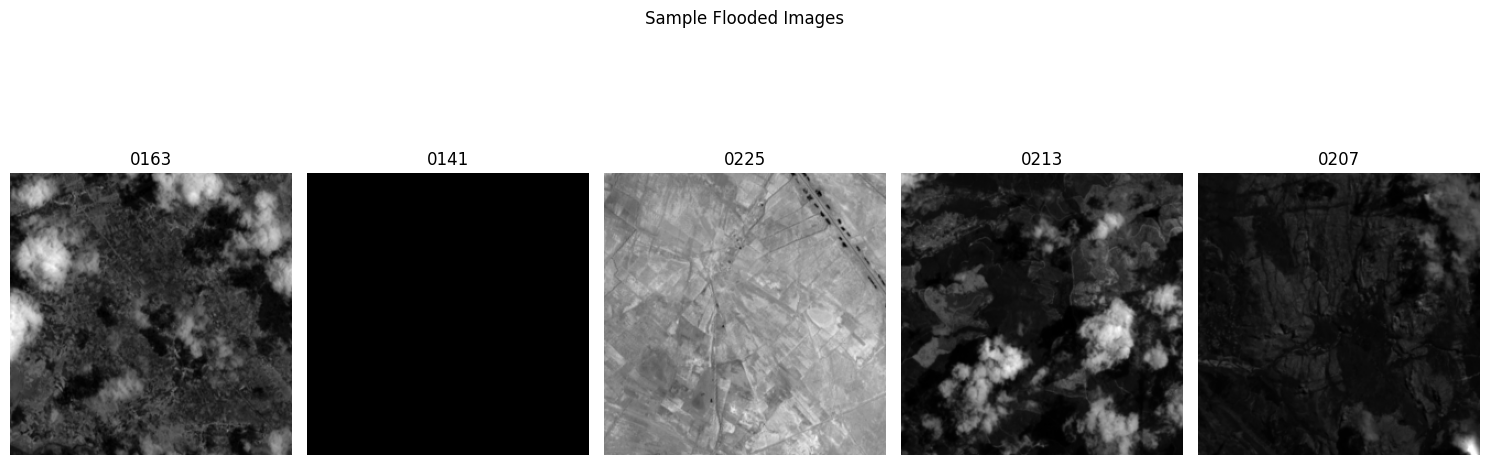

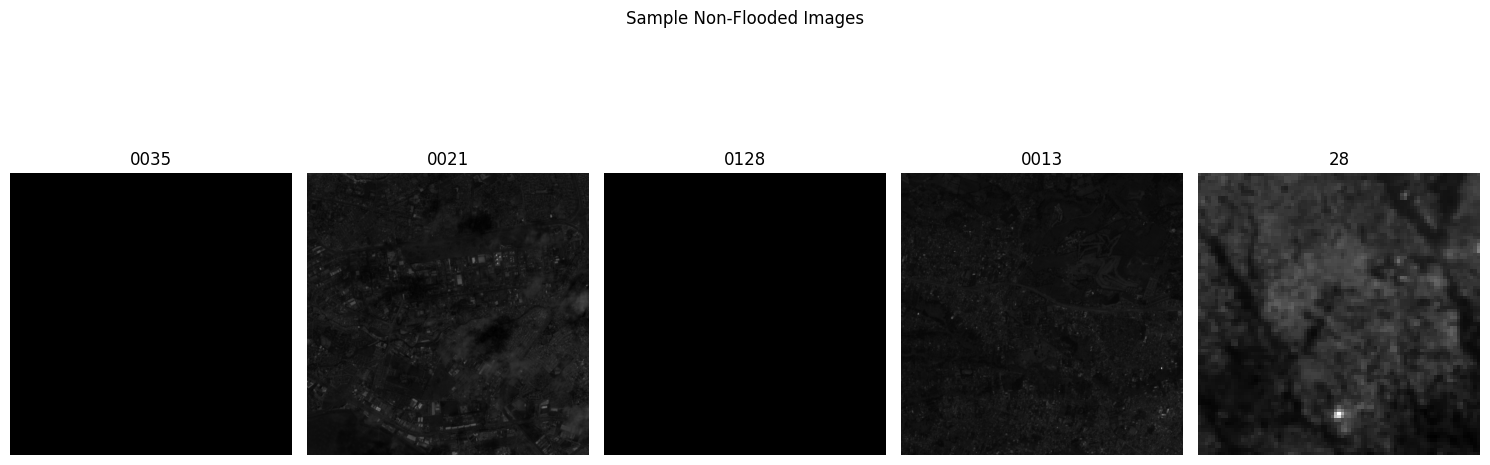

In [34]:
# Display sample of flood labels
print("Flood Label Mapping (Sample):")
for folder, label in list(flood_labels.items())[:10]:
    print(f"Folder: {folder}, Flooding: {label}")

# Get label distribution
dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]
label_counts = Counter(mapped_labels)
print(f"Flooded images: {label_counts[1]}")
print(f"Non-flooded images: {label_counts[0]}")

# Function to load and process images
def load_raw_greyscale_image(image_filepath):
    try:
        with rasterio.open(image_filepath) as src:
            image_data = src.read(1).astype(float)

        # Contrast stretching
        pixel_min = np.nanmin(image_data)
        pixel_max = np.nanmax(image_data)

        if pixel_max > pixel_min:
            stretched_image = (image_data - pixel_min) / (pixel_max - pixel_min)
        else:
            stretched_image = np.zeros_like(image_data)

        # Convert to 8-bit
        greyscale_image = (stretched_image * 255).clip(0, 255).astype(np.uint8)
        return greyscale_image
    except Exception as e:
        print(f"Error loading {image_filepath}: {e}")
        return np.zeros((256, 256), dtype=np.uint8)  # Return empty image on error

# Split files by label
flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 1]
non_flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 0]

print("Number of flooded images:", len(flooded_files))
print("Number of non-flooded images:", len(non_flooded_files))

# Display sample images
def display_sample_images(image_files, title, num_samples=5):
    # Randomly sample images if we have more than needed
    if len(image_files) > num_samples:
        sample_files = random.sample(image_files, num_samples)
    else:
        sample_files = image_files

    plt.figure(figsize=(15, 6))
    for idx, image_path in enumerate(sample_files):
        greyscale_img = load_raw_greyscale_image(image_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(greyscale_img, cmap="gray")
        plt.title(os.path.basename(os.path.dirname(image_path)))
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(flooded_files, "Sample Flooded Images")
display_sample_images(non_flooded_files, "Sample Non-Flooded Images")

The script successfully found 28,300 TIFF files in the dataset directory, with sample paths indicating both Sentinel-1 (S1) radar images in different polarizations (VV and VH) and potentially Sentinel-2 optical images. The dataset contains images organized in numbered folders (like 0005, 0063, etc.).The flood label mapping extracted from the metadata shows a binary classification where 1 indicates flooded areas and 0 indicates non-flooded areas. Based on this mapping, the dataset contains 17,967 flooded images (approximately 63%) and 10,333 non-flooded images (approximately 37%).

The visualizations of sample images show noticeable differences between flooded and non-flooded areas, with flooded images typically showing more distinct patterns of water bodies and different texture characteristics, though some images appear very dark and may require additional preprocessing to enhance features.

In [35]:
#Optional: For Sentinel-1 radar (SAR) data
#You can visualize radar data like this (single band or false-color combo):

def show_sar_bands(image_path):
    with rasterio.open(image_path) as src:
        img = src.read(1)
    plt.imshow(img, cmap="gray")
    plt.title("SAR (VV or VH)")
    plt.axis("off")
    plt.show()

#Or if you have both VV and VH, do a false-color:

def show_sar_rgb(vv_path, vh_path):
    with rasterio.open(vv_path) as src1, rasterio.open(vh_path) as src2:
        vv = src1.read(1)
        vh = src2.read(1)
        diff = vv - vh
        img = np.stack([vv, vh, diff], axis=-1)
        img = img.astype(np.uint8)

    plt.imshow(img)
    plt.title("SAR False Color (VV, VH, VV-VH)")
    plt.axis("off")
    plt.show()

# 2. Data Preprocessing Pipeline

Standard practice is:

Keep the dataset as raw as possible

Apply:

augmentation + resize/normalize for training

just resize/normalize for validation and test

By applying these transformations after splitting, you can:

Apply different transforms per subset

Make training robust (via augmentation)

Keep validation/test clean for fair evaluation

In [36]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

# Config
data_dir = "/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD"
all_folders = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
print(f"Found {len(all_folders)} folders.")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Found 335 folders.


In [37]:
def read_rgb_from_folder(folder_path):
    try:
        files = [f for f in os.listdir(folder_path) if f.endswith(".tif") and "B0" in f]

        # Organize by date
        band_dict = {}
        for f in files:
            parts = f.split("_")
            if len(parts) < 3:
                continue  # Skip unexpected filenames
            date = parts[1]
            band = parts[2].replace(".tif", "")
            band_dict.setdefault(date, {})[band] = f

        # Find the first valid date with B02, B03, B04
        for date, bands in band_dict.items():
            if all(b in bands for b in ["B02", "B03", "B04"]):
                r_path = os.path.join(folder_path, bands["B04"])
                g_path = os.path.join(folder_path, bands["B03"])
                b_path = os.path.join(folder_path, bands["B02"])

                r = rasterio.open(r_path).read(1).astype(np.float32)
                g = rasterio.open(g_path).read(1).astype(np.float32)
                b = rasterio.open(b_path).read(1).astype(np.float32)

                # Normalize using percentile stretch
                def normalize_band(band):
                    p2, p98 = np.percentile(band, (2, 98))
                    band = np.clip((band - p2) / (p98 - p2 + 1e-5), 0, 1)
                    return band

                r, g, b = normalize_band(r), normalize_band(g), normalize_band(b)

                rgb = np.stack([r, g, b], axis=-1)
                rgb = (rgb * 255).astype(np.uint8)
                return Image.fromarray(rgb)

        raise RuntimeError("No common date with all 3 bands found.")

    except Exception as e:
        raise RuntimeError(f"Error reading RGB bands in {folder_path}: {e}")

In [38]:
import os
from collections import defaultdict

def is_valid_folder(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.endswith(".tif") and "B0" in f]
    band_dates = defaultdict(set)

    for file in tif_files:
        parts = file.split('_')
        if len(parts) < 3:
            continue
        _, date, band = parts[0], parts[1], parts[2].replace(".tif", "")
        band_dates[date].add(band)

    for date, bands in band_dates.items():
        if {'B02', 'B03', 'B04'}.issubset(bands):
            return True  # Valid: has all 3 bands for one date

    return False  # No date had all 3 bands

In [39]:
from tqdm import tqdm
folder_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))] # Define folder_paths
valid_folders = []
invalid_folders = []

for folder in tqdm(folder_paths):
    if is_valid_folder(folder):
        valid_folders.append(folder)
    else:
        invalid_folders.append(folder)

print(f" Valid folders: {len(valid_folders)} / {len(folder_paths)}")

100%|██████████| 335/335 [00:00<00:00, 506.36it/s]

 Valid folders: 300 / 335


This uses ESA's recommendation for reflectance scaling (assuming input is uint16). You could exclude or mark cloudy samples to improve learning quality.

2. Try different normalization methods
If 2–98% percentile stretch is too aggressive, you could: band = np.clip(band / 10000.0, 0, 1)

you need to select a single date from the available ones in each folder, because each RGB image must be composed from bands (B02, B03, B04) captured on the same day. Sentinel-2 takes images on different days, and having mismatched timestamps across bands can lead to corrupted or meaningless RGB outputs.

300 valid folders out of 335 means your dataset is now clean and ready for model training using only Sentinel-2 RGB bands with matching acquisition dates.

In [40]:
# Shuffle and split ONLY valid folders
random.shuffle(valid_folders)
train_size = int(0.7 * len(valid_folders))
val_size = int(0.15 * len(valid_folders))
test_size = len(valid_folders) - train_size - val_size

train_folders = valid_folders[:train_size]
val_folders = valid_folders[train_size:train_size + val_size]
test_folders = valid_folders[train_size + val_size:]

In [41]:
# Dataset
class Sentinel2RGBDataset(Dataset):
    def __init__(self, folder_paths, label_map, transform=None):
        self.folder_paths = folder_paths
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.folder_paths)

    def __getitem__(self, idx):
        tries = 0
        while tries < 5:
            folder = self.folder_paths[idx]
            folder_name = os.path.basename(folder)
            label = self.label_map.get(folder_name, 0)
            try:
                image = read_rgb_from_folder(folder)
                if self.transform:
                    image = self.transform(image)
                return image, label
            except Exception as e:
                print(f"Skipping folder {folder}: {e}")
                idx = (idx + 1) % len(self.folder_paths)
                tries += 1
        return torch.zeros((3, 224, 224)), 0  # fallback


# Datasets & Loaders
train_dataset = Sentinel2RGBDataset(train_folders, flood_labels, transform=train_transform)
val_dataset = Sentinel2RGBDataset(val_folders, flood_labels, transform=val_test_transform)
test_dataset = Sentinel2RGBDataset(test_folders, flood_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check a sample
images, labels = next(iter(train_loader))
print(f"Sample batch shape: {images.shape}, labels: {labels[:5]}")

Sample batch shape: torch.Size([32, 3, 224, 224]), labels: tensor([1, 1, 0, 1, 0])


In [42]:
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 210, Val: 45, Test: 45


This code prepares satellite images for a flood detection system. First, it resizes all images to the same size (224×224 pixels) so they fit what the neural network expects. Then it converts the images to a format called tensors that deep learning models can work with, and normalizes the pixel values to make the training process more effective. The code splits the 28,300 images into three groups: **70%** for training the model, **15%** for checking its progress during training, and **15%** for final testing.

1. Each folder = 1 spatial-temporal sample
In Sen12Flood, each folder corresponds to a unique scene at a specific time and location. That means:

The bands B04, B03, B02 inside a folder are all from the same spatial-temporal context.

If you split at the image level instead of the folder level, you risk data leakage — similar-looking images (e.g., same area, different bands or timestamps) could end up in both training and test sets.

2. Spatial autocorrelation
Remote sensing data often suffers from spatial autocorrelation — nearby pixels or scenes are not independent. So randomly splitting pixels or even individual images across folders can make the test performance look better than it actually is.

That’s why it’s best practice to:

Split by scene or folder, not by image.

Ensure each split contains unique scenes.

3. Sen12Flood follows this pattern
Sen12Flood isn't split randomly at the pixel or image level either. It’s typically split by folders/scenes for the same reason — to prevent leakage and ensure generalization across different geographic locations.

So in short: Yes, your approach is the right way to handle Sen12Flood. Avoid splitting the dataset at the image level, especially in geospatial tasks. Folder-level splits based on scene ensure valid, non-leaky training and evaluation.

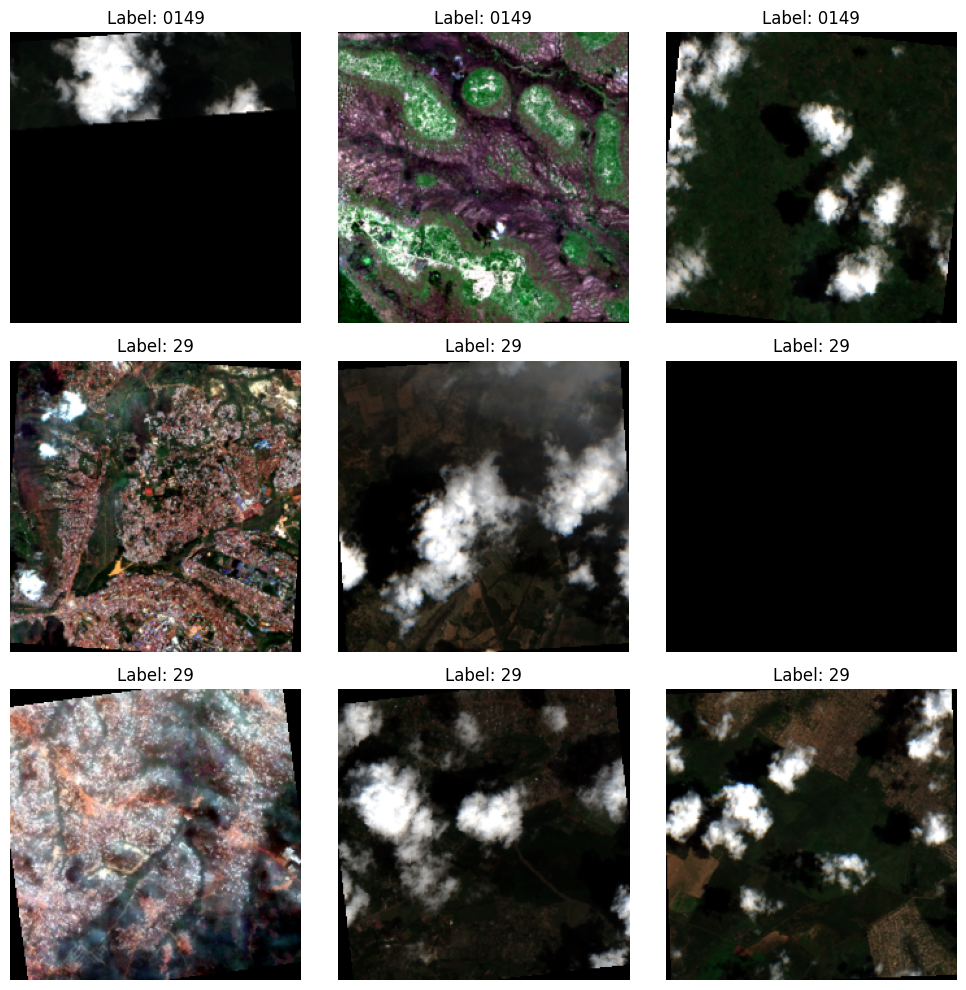

In [43]:
# Helper to unnormalize the image for display
def unnormalize(tensor):
    """Convert normalized image tensor back to [0, 1] for display"""
    tensor = tensor * 0.5 + 0.5  # Assuming normalization mean=0.5, std=0.5
    return tensor

# Define class label names for visualization
label_names = {v: k for k, v in flood_labels.items()}  # e.g., {0: 'nonflooded', 1: 'flooded'}

# Plot a few images from the training dataset
def plot_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        image, label = dataset[i]
        image = unnormalize(image)  # Undo normalization
        image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting

        plt.subplot(3, 3, i + 1)
        plt.imshow(image_np)
        plt.title(f"Label: {label_names.get(label, label)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples
plot_samples(train_dataset)

UN-SPIDER Workflow
United Nations Platform for Space-based Information for Disaster Management and Emergency Response

🔍 Model Type: Threshold-based / rule-based with optional ML integration
Core Idea: Uses Sentinel-1 SAR (VV/VH) backscatter before and after the event.

Methodology:

Pre-event and post-event image comparison

Apply thresholds (e.g., 2–3 dB difference) to detect permanent water vs flooded areas

Uses Normalized Difference Flood Index (NDFI) or ratio/mean change detection

📌 Sometimes integrates:
Decision trees

Simple classifiers (Random Forests, SVM) — if training data available

Often paired with GIS layers (elevation, land use)

Goal: Simple, operational, fast – especially when computational power is limited in disaster zones

WorldFloods (Oxford / Frontier Development Lab)
🔍 Model Type: Deep Learning (U-Net)
Developed as part of ESA’s WorldFloods with Oxford and the UN.

Architecture:

U-Net convolutional neural network

Takes Sentinel-1 SAR (VV/VH) images as input

Outputs a pixel-wise binary flood mask

Key Features:

Trained on 13 flood events across different countries

Multi-temporal Sentinel-1 inputs (before, during, after)

Works well in cloud-prone areas (where optical imagery fails)

Model Characteristics:

Input: 2-3 SAR bands (VV before, VV after, VH after)

Output: Raster map of flooded areas (same size as input)

Can run on low-cost hardware (e.g., Raspberry Pi)





# **Model Part start from here:**

Model	Type	Use Case Fit	Notes
CNN	Deep learning	Image-level classification	Great for detecting if an image (or patch) is flooded
U-Net	Deep learning	Pixel-level segmentation	Ideal for flood masks — where is the water?
Random Forest	Traditional ML	Patch or feature-based classification	Good baseline, but needs flattening + hand-crafted features

Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Step 1: Convert Images to Flattened Numpy Arrays
def loader_to_numpy(dataloader):
    images_list, labels_list = [], []
    for images, labels in tqdm(dataloader):
        imgs_np = images.numpy()  # Convert to numpy
        lbls_np = labels.numpy()
        imgs_np = imgs_np.reshape(imgs_np.shape[0], -1)  # Flatten: (3, 224, 224) → (150528,)
        images_list.append(imgs_np)
        labels_list.append(lbls_np)
    return np.vstack(images_list), np.concatenate(labels_list)

# Extract training and testing data
X_train, y_train = loader_to_numpy(train_loader)
X_val, y_val = loader_to_numpy(val_loader)
X_test, y_test = loader_to_numpy(test_loader)


100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


In [46]:
# save datasets for use as pytorch tensors. Will need to be converted to numpy arrays for Random Forest. Use as tensors for CNN.
import torch

torch.save((X_train, y_train), '/content/drive/MyDrive/Final_Deep Learning/train_data.pt')
torch.save((X_val, y_val), '/content/drive/MyDrive/Final_Deep Learning/val_data.pt')
torch.save((X_test, y_test), '/content/drive/MyDrive/Final_Deep Learning/test_data.pt')

np.savez('/content/drive/MyDrive/Final_Deep Learning/train_data.npz', X=X_train, y=y_train)
np.savez('/content/drive/MyDrive/Final_Deep Learning/val_data.npz', X=X_val, y=y_val)
np.savez('/content/drive/MyDrive/Final_Deep Learning/test_data.npz', X=X_test, y=y_test)

In [47]:
X_train, y_train = torch.load('/content/drive/MyDrive/Final_Deep Learning/train_data.pt', weights_only=False)
X_val, y_val = torch.load('/content/drive/MyDrive/Final_Deep Learning/val_data.pt', weights_only=False)
X_test, y_test = torch.load('/content/drive/MyDrive/Final_Deep Learning/test_data.pt', weights_only=False)


In [48]:
# load as numpy array
train_data = np.load('/content/drive/MyDrive/Final_Deep Learning/train_data.npz')
X_train, y_train = train_data['X'], train_data['y']

val_data = np.load('/content/drive/MyDrive/Final_Deep Learning/val_data.npz')
X_val, y_val = val_data['X'], val_data['y']

test_data = np.load('/content/drive/MyDrive/Final_Deep Learning/test_data.npz')
X_test, y_test = test_data['X'], test_data['y']

In [57]:
depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
print(f"Average tree depth: {np.mean(depths):.2f}, Max tree depth: {np.max(depths)}")


AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

Random Forest trees are already shallow, even though you set max_depth to 15 or 25. The average depth of ~7 and maximum of 12 means:
1.   The model finds good splits early on.
2.   The training data is either clean, limited in complexity, or the splits become pure fast (i.e., not much gain from going deeper).

In [58]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    max_features='sqrt',
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1)

# 5-Fold Stratified Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

rf_model.fit(X_train, y_train)

Cross-Validation Accuracy Scores: [0.78571429 0.69047619 0.64285714 0.66666667 0.52380952]
Mean CV Accuracy: 0.6619 ± 0.0844


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)


Validation Set Evaluation:
Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.21      0.31        19
           1       0.61      0.88      0.72        26

    accuracy                           0.60        45
   macro avg       0.59      0.55      0.51        45
weighted avg       0.59      0.60      0.55        45



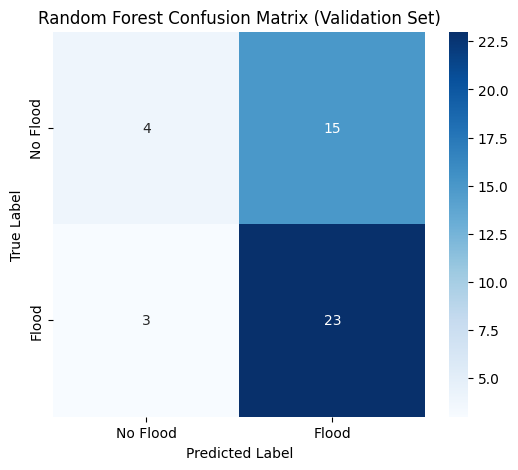

In [59]:
# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Performance evaluation
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix Plot
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap="Blues", xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.title("Random Forest Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

AUC: 0.7055


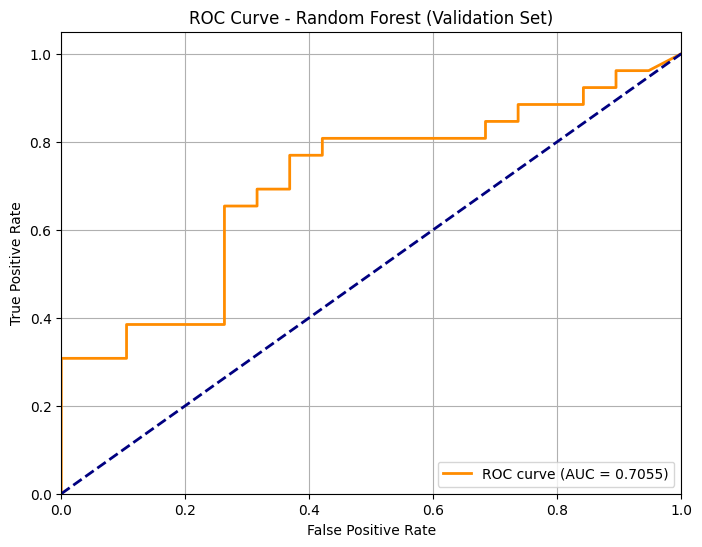

In [60]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Get probability estimates for class 1 ("Flood")
y_val_probs = rf_model.predict_proba(X_val)[:, 1]  # Get probs for class 1
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


used this as reference: https://nhess.copernicus.org/articles/21/807/2021/ for random forest features

# SmallFlood CNN

1. CNN – Image Classification
🔍 Goal:
Classify full image or patches into categories: flooded vs non-flooded.

✅ Pipeline:
Input: RGB (or SAR) tiles resized to 224x224

Model: Simple CNN or pre-trained ResNet/VGG via Keras

Output: Single label (flooded = 1, nonflooded = 0)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallFloodCNN(nn.Module):
    def __init__(self):
        super(SmallFloodCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # (16, 224, 224)
        self.pool = nn.MaxPool2d(2, 2)  # → (16, 112, 112)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (32, 112, 112) → (32, 56, 56)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (64, 28, 28)

        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(64 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, 2)  # 2 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # (32, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # (64, 28, 28)

        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallFloodCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [63]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Train Acc: {train_acc:.2f}%")



In [64]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")


In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model(model, test_loader)


Accuracy: 0.5333333333333333
Precision: 0.5333333333333333
Recall: 1.0
F1 Score: 0.6956521739130435
              precision    recall  f1-score   support

    No Flood       0.00      0.00      0.00        21
       Flood       0.53      1.00      0.70        24

    accuracy                           0.53        45
   macro avg       0.27      0.50      0.35        45
weighted avg       0.28      0.53      0.37        45



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


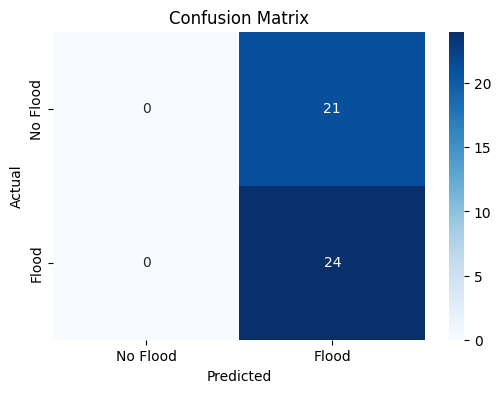

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

target_names = ['No Flood', 'Flood']
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Your model never predicts "No Flood", which causes:

Recall for "Flood" to be perfect (it never misses a flood).

But Precision suffers (it often mistakes No Flood for Flood).

This likely indicates class imbalance or bias in predictions.

# ResNet CNN

In [67]:
import torch.nn as nn
import torchvision.models as models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
class FloodResNet(nn.Module):
    def __init__(self):
        super(FloodResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)

        # Modify final layer for binary classification
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 2)  # Binary output

    def forward(self, x):
        return self.base_model(x)

# Instantiate the model and move it to the device
model = FloodResNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Since output is 2 logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 248MB/s]


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.5889
Epoch [2/10], Loss: 0.2394
Epoch [3/10], Loss: 0.1718
Epoch [4/10], Loss: 0.0893
Epoch [5/10], Loss: 0.0779
Epoch [6/10], Loss: 0.1116
Epoch [7/10], Loss: 0.0937


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_curve, auc
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['No Flood', 'Flood'])

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet (Validation Set)')
plt.show()

In [ ]:
all_probs = []  # collect probabilities for class 1

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class 1 (Flood)

        all_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Setup
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

res_train_losses, res_train_accuracies = [], []
res_val_losses, res_val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer_resnet, criterion, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    res_train_losses.append(train_loss)
    res_train_accuracies.append(train_acc)
    res_val_losses.append(val_loss)
    res_val_accuracies.append(val_acc)

    print(f"\n🧠 ResNet - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("⚠️ Early stopping due to no improvement.")
            break


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(res_train_losses, label='Train Loss')
plt.plot(res_val_losses, label='Val Loss')
plt.title('ResNet Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(res_train_accuracies, label='Train Accuracy')
plt.plot(res_val_accuracies, label='Val Accuracy')
plt.title('ResNet Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# EfficientNet

In [ ]:
!pip install timm
import timm
import torch.nn as nn
import torch.optim as optim

# Load EfficientNet-B0 with pretrained weights
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify classifier layer for binary classification
num_features = efficientnet_model.get_classifier().in_features
efficientnet_model.classifier = nn.Linear(num_features, 2)

efficientnet_model = efficientnet_model.to(device)
print("EfficientNet-B0 loaded and ready for binary classification.")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_eff = optim.AdamW(efficientnet_model.parameters(), lr=1e-4)

num_epochs = 50
patience = 3
early_stop_threshold = 0.001

eff_train_losses, eff_train_accuracies = [], []
eff_val_losses, eff_val_accuracies = [], []

best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(efficientnet_model, train_loader, optimizer_eff, criterion, device)
    val_loss, val_acc = validate_epoch(efficientnet_model, val_loader, criterion, device)

    eff_train_losses.append(train_loss)
    eff_train_accuracies.append(train_acc)
    eff_val_losses.append(val_loss)
    eff_val_accuracies.append(val_acc)

    print(f"\n📦 Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    if val_loss < early_stop_threshold:
        print("✅ Validation loss is negligible — early stopping.")
        break

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⚠️ No improvement for {patience} epochs — early stopping.")
            break


took 23 mins

In [ ]:
efficientnet_model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = efficientnet_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Prob of class 1 (Flood)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


In [ ]:
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['No Flood', 'Flood'])

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet (Validation Set)')
plt.show()


In [ ]:
# roc
all_probs = []  # collect probabilities for class 1

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class 1 (Flood)

        all_probs.extend(probs.cpu().numpy())
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNet (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Prediction